# GPT-4o Based Rehab Exercise Evaluation

Based on https://github.com/openai/openai-cookbook/blob/main/examples/gpt4o/introduction_to_gpt4o.ipynb

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from constants import *
from pathlib import Path

import cv2
import json
import time
import base64
import pickle as pkl
from tqdm import tqdm
from glob import glob
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display, Markdown

In [ ]:
!pip install --upgrade openai
!pip install --upgrade ollama

## Combine Tables to Obtain Trimmed Video Clips for each Repetition

Organize File Directories

In [97]:
vid2stamp = pd.read_csv('./kimore_annotations_all_exercises.csv')
id2vid = pd.read_csv('./video_person_exercise_mapping.csv')

In [98]:
id2vid.head()

,PersonID,ExerciseNum,AnnotationVideoNum
0,E_ID12,0,V1
1,P_ID11,0,V10
2,NE_ID19,0,V11
3,NE_ID14,0,V12
4,B_ID1,0,V13


In [99]:
vid2stamp.head()

,Exercise,Video,Repetition,Start,End,Incomplete
0,Exercise_0,V1,1,0:00:00.94,0:00:05.22,0
1,Exercise_0,V1,2,0:00:05.22,0:00:10.58,0
2,Exercise_0,V1,3,0:00:10.58,0:00:15.90,0
3,Exercise_0,V1,4,0:00:15.90,0:00:20.70,0
4,Exercise_0,V1,5,0:00:20.70,0:00:25.58,0


In [100]:
id2vid['exe_vid'] = id2vid['ExerciseNum'].astype(str) + id2vid['AnnotationVideoNum']
vid2stamp['Exercise'] = vid2stamp['Exercise'].str.replace('Exercise_', '')
vid2stamp['exe_vid'] = vid2stamp['Exercise'] + vid2stamp['Video']

In [101]:
id2stamp = vid2stamp.join(id2vid.set_index('exe_vid'), on='exe_vid', how='left').drop(columns=['AnnotationVideoNum', 'Video', 'Incomplete', 'ExerciseNum', 'exe_vid'])

In [102]:
id2stamp.to_csv('./id2stamp.csv', index=False)

In [103]:
id2stamp = pd.read_csv('./id2stamp.csv')

In [104]:
# Constructing a filename
id2stamp['Exercise_1start'] = id2stamp['Exercise'].astype(int) +1
id2stamp['person_ex'] = id2stamp['PersonID'].astype(str) + "_Es" + id2stamp['Exercise_1start'].astype(str) 
# id2stamp['fname'] = id2stamp['PersonID'].astype(str) + "_Es" + id2stamp['Exercise'].astype(str) + "_" + id2stamp['Repetition'].astype(str)

In [105]:
id2stamp.head()

,Exercise,Repetition,Start,End,PersonID,Exercise_1start,person_ex
0,0,1,0:00:00.94,0:00:05.22,E_ID12,1,E_ID12_Es1
1,0,2,0:00:05.22,0:00:10.58,E_ID12,1,E_ID12_Es1
2,0,3,0:00:10.58,0:00:15.90,E_ID12,1,E_ID12_Es1
3,0,4,0:00:15.90,0:00:20.70,E_ID12,1,E_ID12_Es1
4,0,5,0:00:20.70,0:00:25.58,E_ID12,1,E_ID12_Es1


In [106]:
float(id2stamp['Start'][0].replace('0:00:', ''))

0.94

Video Processing Funcs

In [109]:
def timestamp_to_seconds(timestamp):
    hours, minutes, seconds = map(float, timestamp.split(':'))
    total_seconds = hours*3600 + minutes * 60 + seconds
    return float(total_seconds)

def process_video(video_path, frames_to_skip=2):
    """Modified from https://github.com/openai/openai-cookbook/blob/main/examples/gpt4o/introduction_to_gpt4o.ipynb"""
    frames, base64Frames, frame_nums = [], [], []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        
        if not success:
            break
        # Resize frame to 224 pixels vertically
        frame = cv2.resize(frame, (int(frame.shape[1] * (224 / frame.shape[0])), 224))
        
        # Crop the middle 224 pixels horizontally
        start_x = int((frame.shape[1] - 224) / 2)
        frame = frame[:, start_x:start_x + 224]
    
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        frames.append(frame)
        frame_nums.append(curr_frame)

        curr_frame += frames_to_skip

    return frames, base64Frames, frame_nums

In [323]:
id2stamp[id2stamp['person_ex'] == 'E_ID6_Es2']

,Exercise,Repetition,Start,End,PersonID,fname,person_ex,Repetition_1start,Exercise_1start
497,1,1,0:00:01.14,0:00:05.56,E_ID6,E_ID6_Es1_1,E_ID6_Es2,2,2
498,1,2,0:00:05.56,0:00:09.18,E_ID6,E_ID6_Es1_2,E_ID6_Es2,3,2
499,1,3,0:00:09.18,0:00:12.85,E_ID6,E_ID6_Es1_3,E_ID6_Es2,4,2
500,1,4,0:00:12.85,0:00:16.64,E_ID6,E_ID6_Es1_4,E_ID6_Es2,5,2
501,1,5,0:00:16.64,0:00:20.31,E_ID6,E_ID6_Es1_5,E_ID6_Es2,6,2


In [ ]:
def threaded(fn):
    def wrapper(*args, **kwargs):
        thread = threading.Thread(target=fn, args=args, kwargs=kwargs)
        thread.start()
        return thread
    return wrapper

class MyClass:
    somevar = 'someval'

    @threaded
    def func_to_be_threaded(self):
        print 'xyz'

In [545]:
def extract_video_from_df(vidfname, id2stamp):
    fname = vidfname.split('/')[2] + "_" + vidfname.split('/')[3]

    rows = id2stamp[id2stamp['person_ex'] == fname]

    if rows.empty:
        return

    frames, base64_frames, frame_count = process_video(vidfname, frames_to_skip=2)

    # for each row/repetition, extract and save the relevant frames
    for _, rep_row in rows.iterrows():
        t_start = timestamp_to_seconds(rep_row['Start'])
        t_end = timestamp_to_seconds(rep_row['End'])
        names = glob(f"./store/{rep_row['PersonID']}_Es{int(rep_row['Exercise'])+1}_{int(rep_row['Repetition'])-1}_s=*")
                     
        if not names:
            # print(f"./store/{rep_row['PersonID']}_Es{int(rep_row['Exercise'])+1}_{int(rep_row['Repetition'])-1}_s=*")
            continue
        name = names[0]

        base64_filename = f"{name}/base64.txt"
        base64_framegroup = []

        for idx, frame_num in enumerate(frame_count):
            if frame_num >= 25*t_start and frame_num <= 25*t_end:
                base64_framegroup.append(base64_frames[idx])

        with open(base64_filename, "w") as f:
            f.seek(0)
            f.truncate()
            for base64Frame in base64_framegroup:
                f.write(base64Frame + "\n")

Video Extraction and saving to base64 strings

In [546]:
vidfnames = glob(f"./rgb/*_ID*/Es*/rgb/*.mp4")

# for each video, get the corresponding rows in id2stamp
for idx, vidfname in enumerate(tqdm(vidfnames)):
    extract_video_from_df(vidfname, id2stamp)

  0%|          | 0/353 [00:00<?, ?it/s]

100%|██████████| 353/353 [1:18:58<00:00, 13.42s/it]


In [1163]:
obj['split']['xsub_val']

['NE_ID26_Es1_0',
 'NE_ID26_Es1_1',
 'NE_ID26_Es1_2',
 'NE_ID26_Es1_3',
 'NE_ID26_Es1_4',
 'NE_ID26_Es2_0',
 'NE_ID26_Es2_1',
 'NE_ID26_Es2_2',
 'NE_ID26_Es2_3',
 'NE_ID26_Es2_4',
 'NE_ID26_Es2_5',
 'NE_ID26_Es2_6',
 'NE_ID26_Es2_7',
 'NE_ID26_Es3_0',
 'NE_ID26_Es3_1',
 'NE_ID26_Es3_2',
 'NE_ID26_Es3_3',
 'NE_ID26_Es3_4',
 'NE_ID26_Es3_5',
 'NE_ID26_Es3_6',
 'NE_ID26_Es3_7',
 'NE_ID26_Es3_8',
 'NE_ID26_Es4_0',
 'NE_ID26_Es4_1',
 'NE_ID26_Es4_2',
 'NE_ID26_Es4_3',
 'NE_ID26_Es4_4',
 'NE_ID26_Es4_5',
 'NE_ID26_Es4_6',
 'NE_ID26_Es4_7',
 'NE_ID26_Es4_8',
 'NE_ID26_Es5_0',
 'NE_ID26_Es5_1',
 'NE_ID26_Es5_2',
 'E_ID13_Es1_0',
 'E_ID13_Es1_1',
 'E_ID13_Es1_2',
 'E_ID13_Es1_3',
 'E_ID13_Es1_4',
 'E_ID13_Es2_0',
 'E_ID13_Es2_1',
 'E_ID13_Es2_2',
 'E_ID13_Es2_3',
 'E_ID13_Es2_4',
 'E_ID13_Es2_5',
 'E_ID13_Es2_6',
 'E_ID13_Es3_0',
 'E_ID13_Es3_1',
 'E_ID13_Es3_2',
 'E_ID13_Es3_3',
 'E_ID13_Es3_4',
 'E_ID13_Es4_0',
 'E_ID13_Es4_1',
 'E_ID13_Es4_2',
 'E_ID13_Es4_3',
 'E_ID13_Es4_4',
 'E_ID13_Es5_0

In [1201]:
# obtain the test set for lmso
df_test_exclude_list = []

obj = None
for fold in range(0, 10):
    with open(f"./LMSO_10/skelton_3D_LMSO_{fold}.pkl", "rb") as f:
        obj = pkl.load(f)
    df_test_exclude_list.extend(obj['split']['xsub_val'])

df_test_exclude = pd.DataFrame(df_test_exclude_list, columns=['pidd']) # contain duplications, but can be removed later
# df_test_exclude.to_csv('./df_test_exclude.csv', index=False)
# df_test_exclude = pd.read_csv('./df_test_exclude.csv')
# df_test_exclude.drop_duplicates(inplace=True, ignore_index=True)
# df_test_exclude

In [1235]:
obj = None
for fold in range(0, 10):
    with open(f"./LMSO_10/skelton_3D_LMSO_{fold}.pkl", "rb") as f:
        obj = pkl.load(f)
    
    all_reps_df.loc[all_reps_df['dir'].str[8:-15].isin(obj['split']['xsub_val']) == True, 'fold_num'] = int(fold)
all_reps_df['fold_num'] = all_reps_df['fold_num'].astype(int)

In [ ]:
# This is used for extracting the frames based on the folds - Deprecated

for fold in range(0, 10):
    with open(f"./LMSO_10/skelton_3D_LMSO_{fold}.pkl", "rb") as f:
        object = pkl.load(f)

    for idx, val in enumerate(tqdm(list(object.values())[1])):
        score = str(int(val['label'][0]))

        name = f"{val['frame_dir']}_s={score}"
        if not os.path.isdir(f'./store/{name}'):
            os.mkdir(f'./store/{name}')
        rep_row = id2stamp[id2stamp['fname'] == val['frame_dir']]

        if rep_row.empty:
            continue

        rep_row = rep_row.iloc[0]

        person_id = rep_row['PersonID']
        exe_id = int(rep_row['Exercise'])

        # get the video file
        vidfnames = glob(f"./rgb/{person_id}/Es{exe_id+1}/rgb/*.mp4")
        if not vidfnames:
            print("Empty video dir")
            continue

Import base64 video Ground Truths 

In [3]:
exercise_num = [1, 2, 3, 4, 5]
score_num = [0, 1, 2, 3]

In [10]:
# build Label dict containing gound truths
dir_labels_gt = {}
exe_labels_gt = {}

for exe in exercise_num:
    dir_labels_gt[exe] = {}
    exe_labels_gt[exe] = {}
    for score in score_num:
        dirs = glob(f"./store/*E_ID*_Es{exe}_*_s={score}")
        if dirs:
            for dir in dirs:
                # Find the first dir that has a base64.txt file
                if os.path.isfile(f"{dir}/base64.txt"):
                    with open(f"{dir}/base64.txt", "r") as f:
                        b64_frames = f.readlines()
                        if len(b64_frames) == 0:
                            continue
                        img_indices = np.linspace(2, len(b64_frames)-2, 5, dtype=int).tolist()
                        exe_labels_gt[exe][score] = [b64_frames[idx] for idx in img_indices]
                        dir_labels_gt[exe][score] = dir
                    break
        else: # need to re-search ground truth in something that is not Expert/NonExpert
            dirs = glob(f"./store/*_ID*_Es{exe}_*_s={score}")
            for dir in dirs:
                # Find the first dir that has a base64.txt file
                if os.path.isfile(f"{dir}/base64.txt"):
                    with open(f"{dir}/base64.txt", "r") as f:
                        b64_frames = f.readlines()
                        if len(b64_frames) == 0:
                            continue
                        img_indices = np.linspace(2, len(b64_frames)-2, 5, dtype=int).tolist()
                        exe_labels_gt[exe][score] = [b64_frames[idx] for idx in img_indices]
                        dir_labels_gt[exe][score] = dir
                    break
b64_frames = None

In [572]:
# Create an empty DataFrame
all_reps_df = pd.DataFrame(columns=['pid', 'exe_num', 'score_gt', 'dir'])

# Iterate over the dir_labels_gt dictionary
for exe_num in range(1,6):
    for score_num in range(0,4):
        file_paths = glob(f'./store/*_Es{exe_num}_*_s={score_num}/base64.txt')
        # print(f'./store/*_Es{exe_num}_*_s={score_num}/base64.txt', len(file_paths))
        # Get the patient ID and score number from the directory path
        for file_path in file_paths:
            fname = file_path.split('/')[-2]
            pid = fname.split('_')[0] + '_' + fname.split('_')[1]
            # Append the data to the DataFrame
            all_reps_df = all_reps_df.append(
                {'pid': pid, 'exe_num': int(exe_num), 'score': int(score_num),
                            'dir': file_path,},
                ignore_index=True
            )


## OAI and Ollama Inference Funcs

In [3]:
exercise_num = [1, 2, 3, 4, 5]
score_num = [0, 1, 2, 3]

In [974]:
# all_reps_df.to_csv('./all_reps_df.csv', index=False)
all_reps_df = pd.read_csv('./all_reps_df_w_q.csv')

Initialize OAI Client

In [425]:
import openai

openai.api_key = oai_key
openai.default_headers = {"OpenAI-Beta": "assistants=v2"}

response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
    {"role": "system", "content": "You are generating a video summary. What is in this video? Respond in Markdown."},
    ]
)

print(response)

ChatCompletion(id='chatcmpl-9Y0I7Pc009ttMv6CUpfxKfLUrT9Iy', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='# Video Summary\n\n## Title\n**"The Secret Behind a Successful Morning Routine"**\n\n## Presenter\n*Ella Smith*\n\n## Duration\n*10:15 minutes*\n\n## Content Overview\n\n### Introduction (0:00 - 1:00)\n- Ella Smith welcomes viewers and introduces the topic of optimizing morning routines for a successful day.\n- Brief mention of the benefits of having a structured morning routine.\n\n### The Importance of a Morning Routine (1:01 - 2:30)\n- Explanation of how a consistent morning routine can improve productivity, mental health, and overall well-being.\n- Mention of scientific studies supporting the importance of starting the day with intention.\n\n### Key Components of a Successful Morning Routine (2:31 - 7:30)\n1. **Wake Up Early** (2:31 - 3:30)\n   - Importance of waking up at the same time every day.\n   - Tips for adjusting t

### OAI Inference Funcs and Defs

In [5]:
MODEL="gpt-4o-mini"
client = OpenAI(api_key=oai_key)

In [167]:
def clean_json_string(json_string):
    pattern = r'^```json\s*(.*?)\s*```$'
    cleaned_string = re.sub(pattern, r'\1', json_string, flags=re.DOTALL)
    return cleaned_string.strip()

# get the exercise description
struc_desc_by_exe = {}
for exe_num in exercise_num:
    with open(f"./struc_data/exec_descs/exec_{exe_num}_desc_nat.md") as f:
        exec_desc = f.read()
        struc_desc_by_exe[exe_num] = exec_desc

# get background description, user intro, answer format, and system intro
(intro_sys, intro_user, background_text,
 struc_desc_text, rep_eval, ans_format) = None, None, None, None, None, None

with open("./struc_data/background_desc/intro_system_video.md") as f:
	intro_sys = f.read()
with open("./struc_data/background_desc/intro_user_video.md") as f:
	intro_user = f.read()
with open("./struc_data/background_desc/backgrounds_videos.md") as f:
	background_text = f.read()
with open("./struc_data/task_descs/rep_eval.md") as f:
	rep_eval = f.read()
with open("./struc_data/ans_format/ans_format.json") as f:
	ans_format = json.dumps(json.load(f))

rep_eval_10q, assess_q, ans_format_0s = None, {}, None
with open("./struc_data/background_desc/backgrounds_10q_0s.md") as f:
	background_10q_0s = f.read()
with open("./struc_data/task_descs/rep_eval_10q.md") as f:
	rep_eval_10q = f.read()
with open("./struc_data/ans_format/ans_format_0s.json") as f:
	ans_format_0s = json.dumps(json.load(f))

for i in range(1,6):
	with open(f"./struc_data/que_format/assess_q_{i}.json") as f:
		assess_q[i]=(json.dumps(json.load(f)))

In [ ]:
def get_gt_b64_from_exe_n_dict(exe_n_labels_gt, detail="low"):
    """wrap Ground truth in base64"""
    gt_exe_b64 = []

    for score in range(0,4):
        gt_exe_b64.append({"type": "text", "text":
            f"BEGINS 5 frames containing the ground truth for this exercise marked with score {score}"})
        seq = map(lambda x: {"type": "image_url",
                            "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": detail}}, exe_n_labels_gt[score])
        gt_exe_b64.extend([*seq])
    gt_exe_b64.append({"type": "text", "text": f"ENDS ground truth sequence"})
    return gt_exe_b64

gt_exe_b64 = get_gt_b64_from_exe_n_dict(exe_labels_gt[2], detail="low")

In [8]:
def get_eval_b64_from_dir(dir_path, detail="low", num_frames=5):
    """Obtaining the evaluation sequence and assemble the b64 array"""
    base64_frames = None
    with open(dir_path) as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        img_indices = np.linspace(1, len(base64_frames)-1, num_frames, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]

    eval_b64 = []
    eval_b64.append({"type": "text", "text":
        f"BEGINS with 5 frames containing the evaluation label for this exercise."})
    seq_e = map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": detail}}, eval_label)
    eval_b64.extend([*seq_e])
    eval_b64.append({"type": "text", "text": f"ENDS with evaluation sequence"})
    return eval_b64

# Obtain one evaluation dataset
# eval_dir = all_reps_df[(all_reps_df['score'] == 3) & (all_reps_df['exe_num'] == 2)]['dir'].iloc[0]
eval_b64 = get_eval_b64_from_dir('./store/NE_ID19_Es2_2_s=3/base64.txt')

In [ ]:
def eval_with_oai(intro_sys, intro_user, background_text, struc_desc_text,
                  rep_eval, gt_exe_b64, eval_b64, ans_format,
                max_tokens=100):
    """Inference Function"""
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": intro_sys},
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval},
            {"role": "assistant", "content": "May I have some background information on the image sequences?"},
            {"role": "user", "content": background_text},
            {"role": "assistant", "content": "Alright. To start off, please provide me with the exercise description."},
            {"role": "user", "content": struc_desc_text},
            {"role": "assistant", "content": "Next, please provide me with the ground truth sequences."},
            {"role": "user", "content": gt_exe_b64},
            {"role": "assistant", "content": "Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user", "content": eval_b64},
            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format},
        ],
        temperature=.5,
        max_tokens=max_tokens,
        # stream=True,
    )
    return response

response = eval_with_oai(intro_sys, intro_user, background_text, struc_desc_by_exe[2],
                         rep_eval, gt_exe_b64, eval_b64, ans_format)
print(json.loads(clean_json_string(response.choices[0].message.content)))
# for chunk in response:
#   print(chunk.choices[0].delta.content, end='', flush=True)

In [ ]:
def eval_with_oai_10q(intro_sys, intro_user, background_text,
                  rep_eval_10q, assess_q, eval_b64, ans_format_0s,
                max_tokens=200, temp=0.5, top_p=1.0):
    """Inference Function"""
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": intro_sys},
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval_10q},
            {"role": "assistant", "content": "May I have some background information on the task?"},
            {"role": "user", "content": background_text},

            {"role": "assistant", "content": "To start off, please provide me with the QS questionnares."},
            {"role": "user", "content": assess_q},

            {"role": "assistant", "content": "Next, Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user", "content": eval_b64},
            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format_0s},
            {"role": "user", "content": "Remember to provide answer in a single JSON object only"},
        ],
        temperature=temp,
        top_p=top_p,
        max_tokens=max_tokens,
        # stream=True,
    )
    return response

response = eval_with_oai_10q(intro_sys, intro_user, background_text,
                         rep_eval_10q, assess_q, eval_b64, ans_format_0s)
print(json.loads(clean_json_string(response.choices[0].message.content)))
# for chunk in response:
#   print(chunk.choices[0].delta.content, end='', flush=True)

### Ollama Inference Funcs and Defs

In [697]:
from ollama import Client
client_ollama = Client(host='http://localhost:11434')

In [754]:
def get_gt_b64_from_exe_n_dict_ollama(exe_n_labels_gt):
    """wrap Ground truth in base64"""
    
    gt_exe_txt, gt_exe_b64 = [], []

    for score in range(0,4):
        gt_exe_txt.append(f"Here are 5 frames containing the ground truth for this exercise marked with score {score}")
        a = [str(frame) for frame in exe_n_labels_gt[score]]
        gt_exe_b64.append(a)

    return (gt_exe_txt, gt_exe_b64)

gt_exe_txt_b64 = get_gt_b64_from_exe_n_dict_ollama(exe_labels_gt[2])

In [762]:
def get_eval_b64_from_dir_ollama(dir_path):
    """Obtaining the evaluation sequence and assemble the b64 array"""
    base64_frames = None
    with open(dir_path) as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        img_indices = np.linspace(1, len(base64_frames)-1, 5, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]

    eval_txt = f"Here are with 5 frames containing the evaluation label for this exercise."
    return (eval_txt, eval_label)

# Obtain one evaluation dataset
eval_dir = all_reps_df[(all_reps_df['score'] == 3) & (all_reps_df['exe_num'] == 2)]['dir'].iloc[0]
eval_txt_b64 = get_eval_b64_from_dir_ollama('./store/NE_ID19_Es2_2_s=3/base64.txt')

In [ ]:
def eval_with_ollama(intro_sys, intro_user, background_text, struc_desc_text,
                  rep_eval, gt_txt_b64, eval_txt_b64, ans_format,
                model_name="llava:34b"):
    """Inference Function"""

    gt_txt, gt_b64 = gt_txt_b64
    eval_txt, eval_b64 = eval_txt_b64

    response = client_ollama.chat(
        model=model_name,
        messages=[
            {"role": "system", "content": intro_sys},
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval},
            {"role": "assistant", "content": "May I have some background information on the image sequences?"},
            {"role": "user", "content": background_text},
            {"role": "assistant", "content": "Alright. To start off, please provide me with the exercise description."},
            {"role": "user", "content": struc_desc_text},

            {"role": "assistant", "content": "Next, please provide me with the ground truth sequences."},
            {"role": "user", "content": gt_txt[0], "images": gt_b64[0]},
            {"role": "user", "content": gt_txt[1], "images": gt_b64[1]},
            {"role": "user", "content": gt_txt[2], "images": gt_b64[2]},
            {"role": "user", "content": gt_txt[3], "images": gt_b64[3]},

            {"role": "assistant", "content": "Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user", "content": eval_txt, "images": eval_b64},

            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format},
        ],
        # stream=True,
        keep_alive=True
    )

    return response

response = eval_with_ollama(intro_sys, intro_user, background_text, struc_desc_by_exe[2],
                         rep_eval, gt_exe_txt_b64, eval_txt_b64, ans_format)
print(json.loads(clean_json_string(response.message.content)))
# for chunk in response:
#   print(chunk.choices[0].delta.content, end='', flush=True)

In [750]:
response

{'model': 'llava:34b',
 'created_at': '2024-06-14T03:26:19.028584296Z',
 'message': {'role': 'assistant',
  'content': 'Sure! Here\'s the JSON object for the given exercise description and sequence:\n```json\n{\n  "exercise_7": {\n    "name": "Lateral tilt of the trunk with the arms in extension",\n    "description": [\n      "The subject has to raise his/her arms above the head with the elbows completely extended and holding a bar with both hands (starting position).",\n      "The subject then has to tilt the trunk slowly first to the left and then to the right, keeping it exactly on the frontal plane.",\n      "After each tilt, the subject returns to the starting position."\n    ],\n    "requirements": [\n      "The movement must be performed so as to avoid bending the trunk backwards or forwards. The feet must always be on the ground, slightly apart, with the knees slightly flexed."\n    ],\n    "maximize": [\n      "Maximize the Left and Right angles between imaginary lines formed 

### Preparation for Batch Inference: Data Table Creation

In [ ]:
all_reps_df['pid_ex'] = all_reps_df['pid'] + '_Es' + all_reps_df['exe_num'].astype(str)

In [1344]:
# Using 2 LMSO folds and 280 samples in total, (5x4 + 3x4)x5 = 160 (-> 200 samples with extras) with mixed patient ID and repetition, 4x5x5=100 samples as LMSO test set
# 4 seen folds for each shot, 4*4*4=64 samples as ground truth 
reps_eval_200 = pd.DataFrame(columns=['pid', 'exe_num', 'score_gt', 'dir', 'score_q_total', 'score_q_po', 'score_q_cf',
                                     'score_inf_total', 'score_inf_po', 'score_inf_cf', 'pid_ex', 'fold_num',
                                     'score_inf_total_m', 'score_inf_po_m', 'score_inf_cf_m',
                                     'inf_reasoning', 'inf_shot_num', 'visibility'])
reps_test_100 = reps_eval_200.copy()

for exe_num in exercise_num:
    for sc_num in score_num:
        df_row = all_reps_df[(all_reps_df['fold_num'] < 5) & (all_reps_df['score_gt'] == sc_num) & (all_reps_df['exe_num'] == exe_num)]
        reps_eval_200 = pd.concat([reps_eval_200, df_row.iloc[::df_row.shape[0]//10][:10]], ignore_index=True)

for exe_num in exercise_num:
    for sc_num in score_num:
        df_row = all_reps_df[(all_reps_df['fold_num'] >= 5) & (all_reps_df['score_gt'] == sc_num) & (all_reps_df['exe_num'] == exe_num)]
        reps_test_100 = pd.concat([reps_test_100, df_row.iloc[::df_row.shape[0]//5][:5]], ignore_index=True)

reps_eval_200['visibility'] = False
reps_test_100['visibility'] = False

In [11]:
# reps_eval_200.to_csv('./reps_eval_200.csv', index=False)
# rep_test_100.to_csv('./rep_test_100.csv', index=False)
reps_eval_200 = pd.read_csv('./reps_eval_200.csv')

In [13]:
# print(dir_labels_gt[1][2])
def visualize_b64_from_dir(dir_path, num_frames=5):
    with open(dir_path) as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        # eval_label = base64_frames[::len(base64_frames)//4]
        img_indices = np.linspace(2, len(base64_frames)-2, num_frames, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]

    for img in eval_label:
        
        display(Image(data=base64.b64decode(img.encode("utf-8")), width=200))

# visualize_b64_from_dir(dir_labels_gt[3][1] + "/base64.txt")

In [14]:
def b64_from_dir_to_png_folder(dir_path, num_frames=5):
    with open(dir_path+"/base64.txt") as f:
        base64_frames = f.readlines()
        if len(base64_frames) == 0:
            return -1
        img_indices = np.linspace(2, len(base64_frames)-2, num_frames, dtype=int).tolist()
        eval_label = [base64_frames[idx] for idx in img_indices]
    if not os.path.exists(f"{dir_path}/pngs"):
        os.mkdir(f"{dir_path}/pngs")
    for idx, img in enumerate(eval_label):
        # Create a PIL Image object from the decoded image data
        with open(f"{dir_path}/pngs/{idx}.png", "wb") as f:
            f.write(base64.b64decode(img.encode("utf-8")))


./store/S_ID9_Es1_2_s=0/base64.txt 26.33333333333333 6.333333333333333 20.0


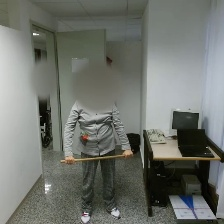

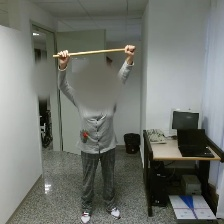

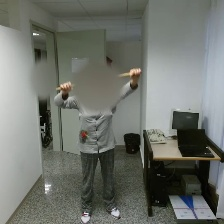

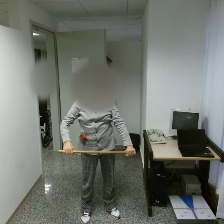

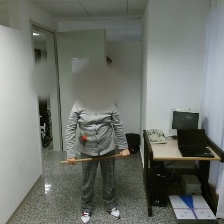

In [152]:
row = reps_eval_200[(reps_eval_200['score_gt'] == 0) & (reps_eval_200['exe_num'] == 1)].iloc[2]
print(row['dir'], row['score_q_total'], row['score_q_po'], row['score_q_cf'])
visualize_b64_from_dir(row['dir'], num_frames=5)

Testing Inference pipeline

In [ ]:
eval_b64 = get_eval_b64_from_dir(row['dir'], detail="low", num_frames=5)
if eval_b64 == -1:
    print("Empty evaluation label")
else:
    # gt_exe_b64 = get_gt_b64_from_exe_n_dict(exe_labels_gt[1], detail="low")
    # exec_desc = struc_desc_by_exe[1]
    response = eval_with_oai_10q(intro_sys, intro_user, background_10q_0s,
                         rep_eval_10q, assess_q, eval_b64, ans_format_0s,
                         max_tokens=400, temp=.1, top_p=.5)
    # inf_score = json.loads(clean_json_string(response.choices[0].message.content))['score']
    # inf_reasoning = json.loads(clean_json_string(response.choices[0].message.content))['reasoning']

In [66]:
ctt = json.loads(clean_json_string(response.choices[0].message.content))
po_score = np.sum(list(ctt['PO_answers'].values())[-3:])
cf_score = np.sum(list(ctt['CF_answers'].values())[-7:])
po_ans_score = np.sum(list(ctt['PO_answers'].values())[:-3])
cf_ans_score = np.sum(list(ctt['CF_answers'].values())[:-7])
print(po_score, cf_score, po_score + cf_score)
# print(po_ans_score, cf_ans_score, po_ans_score + cf_ans_score)
print(" Q:")
print(po_score/15, cf_score/35, (po_score + cf_score)/50)
print(" PO/CF:")
print(po_ans_score/10, cf_ans_score/40, (po_ans_score + cf_ans_score)/50)
print(" GT:")
print(row['score_q_po']/15, row['score_q_cf']/35, row['score_q_total']/50,)

11 21 32
 Q:
0.7333333333333333 0.6 0.64
 PO/CF:
0.8 0.675 0.7
 GT:
0.4222222222222222 0.5714285714285714 0.5266666666666666


In [67]:
ctt

{'PO_answers': {'x': 4, 'y': 4, '1': 4, '2': 3, '3': 4},
 'CF_answers': {'a': 4,
  'b': 4,
  'c': 3,
  'd': 3,
  'e': 3,
  'f': 3,
  'g': 4,
  'h': 3,
  '4': 3,
  '5': 3,
  '6': 3,
  '7': 3,
  '8': 3,
  '9': 3,
  '10': 3},
 'reasoning': {'1': 'Both arms raised to maximum angle',
  '2': 'Rise and fall times are not perfectly equal',
  '3': 'Movement amplitude is maximized at the middle frame',
  '4': 'Head posture is generally correct',
  '5': 'Right arm posture is generally correct',
  '6': 'Left arm posture is generally correct',
  '7': 'Trunk posture is generally correct',
  '8': 'Pelvis posture is generally correct',
  '9': 'Right leg posture is generally correct',
  '10': 'Left leg posture is generally correct'}}

## Batch Inference

In [94]:
# for each exercise and each score
for exe_num in [1,]:

    # get the ground truth base64 and execise description
    # gt_exe = exe_labels_gt[exe_num]
    # exec_desc = struc_desc_by_exe[exe_num]

    cnt = 0

    for sc_num in score_num[1:]:
        exe_sc_rows = reps_eval_200[(reps_eval_200['score_gt'] == sc_num) & (reps_eval_200['exe_num'] == exe_num)].iloc[:10]

        for idx, row in exe_sc_rows.iterrows(): # for 5 reps in each score and exercise
            eval_b64 = get_eval_b64_from_dir(row['dir'], detail="high")
            if eval_b64 is None:
                continue
            # gt_exe_b64 = get_gt_b64_from_exe_n_dict(gt_exe,  detail="high")

            response = eval_with_oai_10q(intro_sys, intro_user, background_10q_0s,
                         rep_eval_10q, assess_q, eval_b64, ans_format_0s,
                         max_tokens=400, temp=.1, top_p=.5)
            
            ctt = json.loads(clean_json_string(response.choices[0].message.content))
            po_score = np.sum(list(ctt['PO_answers'].values())[-3:])
            cf_score = np.sum(list(ctt['CF_answers'].values())[-7:])
            po_ans_score = np.sum(list(ctt['PO_answers'].values())[:-3])
            cf_ans_score = np.sum(list(ctt['CF_answers'].values())[:-7])
            inf_reasoning = ctt['reasoning']

            # 10 q scores
            reps_eval_200.loc[idx, 'score_inf_total'] = po_score + cf_score
            reps_eval_200.loc[idx, 'score_inf_po'] = po_score
            reps_eval_200.loc[idx, 'score_inf_cf'] = cf_score

            reps_eval_200.loc[idx, 'score_inf_total_m'] = po_ans_score + cf_ans_score
            reps_eval_200.loc[idx, 'score_inf_po_m'] = po_ans_score
            reps_eval_200.loc[idx, 'score_inf_cf_m'] = cf_ans_score

            reps_eval_200.loc[idx, 'inf_reasoning'] = str(inf_reasoning)
            reps_eval_200.loc[idx, 'inf_shot_num'] = 0
            
            cnt += 1
            print(f"{cnt}: Exercise {exe_num}, Score {sc_num},\
                  gt = {reps_eval_200.loc[idx, 'score_q_total']:.2f}, inf = {reps_eval_200.loc[idx, 'score_inf_total']}")

1: Exercise 1, Score 1,                  gt = 34.31, inf = 32.0
2: Exercise 1, Score 1,                  gt = 38.00, inf = 37.0
3: Exercise 1, Score 1,                  gt = 39.67, inf = 39.0
4: Exercise 1, Score 1,                  gt = 35.67, inf = 36.0
5: Exercise 1, Score 1,                  gt = 38.00, inf = 36.0
6: Exercise 1, Score 1,                  gt = 35.67, inf = 36.0
7: Exercise 1, Score 1,                  gt = 38.00, inf = 32.0
8: Exercise 1, Score 1,                  gt = 36.00, inf = 39.0
9: Exercise 1, Score 1,                  gt = 39.67, inf = 40.0
10: Exercise 1, Score 1,                  gt = 39.67, inf = 36.0
11: Exercise 1, Score 2,                  gt = 44.33, inf = 32.0
12: Exercise 1, Score 2,                  gt = 41.00, inf = 36.0
13: Exercise 1, Score 2,                  gt = 44.00, inf = 41.0
14: Exercise 1, Score 2,                  gt = 40.00, inf = 32.0
15: Exercise 1, Score 2,                  gt = 44.00, inf = 36.0
16: Exercise 1, Score 2,          

Designated 4-class classifications: 0-30=bad, 30-40=good, 40-45=very good, 45-50=perfect

In [93]:
reps_eval_200.loc[0, 'inf_reasoning']

"{'1': 'Both arms raised to a high angle.', '2': 'Rise time and fall time are not perfectly equal.', '3': 'Movement amplitude is maximized at the middle frame.', '4': 'Head posture is mostly correct.', '5': 'Right arm posture is mostly correct.', '6': 'Left arm posture is mostly correct.', '7': 'Trunk posture is mostly correct.', '8': 'Pelvis posture is mostly correct.', '9': 'Right leg posture is mostly correct.', '10': 'Left leg posture is mostly correct.'}"

In [1346]:
# for each exercise and each score
for exe_num in exercise_num:

    # get the ground truth base64 and execise description
    # gt_exe = exe_labels_gt[exe_num]
    # exec_desc = struc_desc_by_exe[exe_num]

    for sc_num in score_num:
        exe_sc_rows = reps_test_100[(reps_test_100['score_gt'] == sc_num) & (reps_test_100['exe_num'] == exe_num)]

        for idx, row in exe_sc_rows.iterrows(): # for 5 reps in each score and exercise
            b64_from_dir_to_png_folder(row['dir'][:-11], num_frames=5)
            fname = glob(f"{row['dir'][:-11]}/pngs/*.png")

            if not os.path.exists(f"./test_100/{row['dir'][8:-11]}"):
                os.mkdir(f"./test_100/{row['dir'][8:-11]}")
                os.mkdir(f"./test_100/{row['dir'][8:-11]}/pngs")

            for ii, file in enumerate(fname):
                # display(Image(filename=file, width=200))
                os.system (f"mv -f {file} {file.replace('store', f'test_100')}")

            # print(exe_num, sc_num, row['pid'])
            # for i in range(5):
            #     display(Image(filename=row['dir'][:-11] + f"/pngs/{i}.png", width=200))

In [ ]:
# for each exercise and each score
for exe_num in exercise_num:

    # get the ground truth base64 and execise description
    gt_exe = exe_labels_gt[exe_num]
    exec_desc = struc_desc_by_exe[exe_num]

    for sc_num in score_num:
        exe_sc_rows = reps_df_100[(reps_df_100['score_gt'] == sc_num) & (reps_df_100['exe_num'] == exe_num)]

        for idx, row in exe_sc_rows.iterrows(): # for 5 reps in each score and exercise
            eval_b64 = get_eval_b64_from_dir(row['dir'], detail="low")
            if eval_b64 is None:
                continue
            gt_exe_b64 = get_gt_b64_from_exe_n_dict(gt_exe,  detail="low")

            response = eval_with_oai(intro_sys, intro_user, background_text, exec_desc,
                                     rep_eval, gt_exe_b64, eval_b64, ans_format, max_tokens=60)
            inf_score = json.loads(clean_json_string(response.choices[0].message.content))['score']
            inf_reasoning = json.loads(clean_json_string(response.choices[0].message.content))['reasoning']

            reps_df_100.loc[idx, 'score_inf'] = int(inf_score)
            reps_df_100.loc[idx, 'inf_reasoning'] = inf_reasoning

            print(reps_df_100.loc[idx])

## Visualize Results

In [9]:
# reps_df_100.to_csv("./reps_df_100.csv", index=False)
reps_df_100 = pd.read_csv("./reps_df_100.csv")

In [103]:
gt_labels, inf_labels = reps_eval_200.loc[:39, 'score_q_total'].to_numpy(), reps_eval_200.loc[:39,'score_inf_total'].to_numpy()

In [104]:
inf_labels.shape, gt_labels.shape

((40,), (40,))

In [115]:
count_gt, _ = np.histogram(gt_labels, bins=[0, 30, 40, 45, 50])
count_inf, _ = np.histogram(inf_labels, bins=[0, 30, 40, 45, 50])

In [131]:
count_gt, count_inf

(array([10, 10, 10, 10]), array([ 1, 34,  3,  2]))

In [130]:
confusion_matrix(np.repeat(np.arange(4,), count_gt), np.repeat(np.arange(4,), count_inf))

array([[ 1,  9,  0,  0],
       [ 0, 10,  0,  0],
       [ 0, 10,  0,  0],
       [ 0,  5,  3,  2]])

In [23]:
from sklearn.metrics import confusion_matrix

cm = []
# Create confusion matrix
for i in range(1, 6):
    cm.append(np.array(confusion_matrix(gt_labels[(i-1)*20:20*i], inf_labels[(i-1)*20:20*i])))

In [133]:
row['pid_ex']

'E_ID12_Es1'

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

plt.clf()

def plot_confusion_matrix(cm, title, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth label')
    plt.xlabel('Predicted label, GPT-4o, detail="low"')
    plt.tight_layout()


confusion_matrix_tot = np.array(
[[ 7,  7, 11,  0],
 [ 4, 11,  8,  2],
 [ 2,  2, 15,  6],
 [ 2,  0, 10, 13],])

class_names = ['0=Bad', '1=Good', '2=Very Good', '3=Perfect']


plt.figure(figsize=(12, 12))

# Plotting the first subfigure
plt.subplot(3, 2, 1)
plot_confusion_matrix(cm[0], '1-Shot Confusion Matrix for Exercise 1, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the second subfigure
plt.subplot(3, 2, 2)
plot_confusion_matrix(cm[1], '1-Shot Confusion Matrix for Exercise 2, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the third subfigure
plt.subplot(3, 2, 3)
plot_confusion_matrix(cm[2], '1-Shot Confusion Matrix for Exercise 3, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the fourth subfigure
plt.subplot(3, 2, 4)
plot_confusion_matrix(cm[3], '1-Shot Confusion Matrix for Exercise 4, \n No Questionnaire', class_names)
# plt.tight_layout()

# Plotting the fourth subfigure
plt.subplot(3, 2, 5)
plot_confusion_matrix(cm[4], '1-Shot Confusion Matrix for Exercise 5, \n No Questionnaire', class_names)

plt.tight_layout()
plt.savefig("confusion_matrix_5cls.png")

# Plotting the fourth subfigure
plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(confusion_matrix_tot, '1-Shot Confusion Matrix for \n 5 Exercises Merged (100 samples), \n No Questionnaire', class_names)

plt.savefig("cm_total.png")
# plt.show()

In [270]:
response.usage

CompletionUsage(completion_tokens=39, prompt_tokens=3319, total_tokens=3358)

## Stateful Queries with GPT-4o Assistant API

In [ ]:
{
    "type": "function",
    "function": {
        "name": "eval_current_sequence",
        "description": "Get the score for the current sequence of images",
        "parameters": {
            "type": "object",
            "properties": {
            "location": {
                "type": "string",
                "description": "The city and state, e.g., San Francisco, CA"
            },
            "unit": 
            {
                "type": "string",
                "enum": ["Celsius", "Fahrenheit"],
                "description": "The temperature unit to use. Infer this from the user's location."
            }
            },
            "required": ["location", "unit"]
            }
    }
},

In [256]:
run = client.beta.threads.runs.create_and_poll(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Now provide your answer in a single JSON object only. DO NOT add ANY additional free-text prefix.",
    )

In [257]:
clear_and_print_response(run, thread)

failed


In [302]:
def clear_and_print_response(run, thread):
    if run.status == 'completed': 
        messages = client.beta.threads.messages.list(
            thread_id=thread.id
        )
        if messages.data:
            for idx, message in enumerate(messages.data):
                print(f"{idx+1}/{len(messages.data)}, {message.role}")
                for content in message.content:
                    # for cont in content:
                    if isinstance(content, openai.types.beta.threads.text_content_block.TextContentBlock):
                        val = content.text.value
                        cleaned_content = re.sub(r"【\d+†source】", "", val)
                        cleaned_content = cleaned_content.strip()
                        print(cleaned_content)
        else:
            print("No messages received.")
    else:
        print(run.status)

def get_latest_response(run, thread):
    if run.status == 'completed': 
        messages = client.beta.threads.messages.list(
            thread_id=thread.id
        )
        if messages.data:
            content = messages.data[0].content[0].text.value
            cleaned_content = re.sub(r"【\d+†source】", "", content)
            cleaned_content = cleaned_content.strip()
            return cleaned_content
        else:
            return -1
    else:
        return run.status

def get_eval_response(row):
    """Get Eval Response String"""

    if row['score_inf_po'] < row['score_q_po']:
        response_str = f"You underestimated the PO score for ground truth by {(row['score_q_po'] - row['score_inf_po'])/row['score_q_po']*100:.2f} %, "
    elif row['score_inf_po'] > row['score_q_po']:
        response_str = f"You overestimated the PO score for ground truth by {(row['score_inf_po'] - row['score_q_po'])/row['score_q_po']*100:.2f} %, "
    else:
        response_str = "You correctly estimated the PO score for ground truth, "
    
    if row['score_inf_cf'] < row['score_q_cf']:
        response_str += f"underestimated the CF score for ground truth by {(row['score_q_cf'] - row['score_inf_cf'])/row['score_q_cf']*100:.2f} %, "
    elif row['score_inf_cf'] > row['score_q_cf']:
        response_str += f"overestimated the CF score for ground truth by {(row['score_inf_cf'] - row['score_q_cf'])/row['score_q_cf']*100:.2f} %, "
    else:
        response_str += "correctly estimated the CF score for ground truth, "

    emo_phrase = ""
    if (row['score_q_total'] - row['score_inf_total'])/row['score_q_total']<0.15:
        emo_phrase = "Keep up the great work!"
    elif (row['score_q_total'] - row['score_inf_total'])/row['score_q_total']<0.3:
        emo_phrase = "Good effort."
    elif (row['score_q_total'] - row['score_inf_total'])/row['score_q_total']>0.5:
        emo_phrase = "Let's do better next time."
    
    if row['score_inf_total'] < row['score_q_total']:
        response_str += f"and underestimated the total score for ground truth by {(row['score_q_total'] - row['score_inf_total'])/row['score_q_total']*100:.2f} %. {emo_phrase}"
    elif row['score_inf_total'] > row['score_q_total']:
        response_str += f"and overestimated the total score for ground truth by {(row['score_inf_total'] - row['score_q_total'])/row['score_q_total']*100:.2f} %. {emo_phrase}"
    else:
        response_str += f"and correctly estimated the total score for ground truth! {emo_phrase}"
    return response_str

def get_eval_response_d(row):
    """Get Eval Response String"""

    if row['score_inf_po'] < row['score_q_po']:
        response_str = f"PO: {(row['score_q_po'] - row['score_inf_po'])/row['score_q_po']*100:.2f} % under, "
    elif row['score_inf_po'] > row['score_q_po']:
        response_str = f"PO: {(row['score_inf_po'] - row['score_q_po'])/row['score_q_po']*100:.2f} % over, "
    else:
        response_str = "PO: correct, "
    
    if row['score_inf_cf'] < row['score_q_cf']:
        response_str += f"CF: {(row['score_q_cf'] - row['score_inf_cf'])/row['score_q_cf']*100:.2f} % under, "
    elif row['score_inf_cf'] > row['score_q_cf']:
        response_str += f"CF: {(row['score_inf_cf'] - row['score_q_cf'])/row['score_q_cf']*100:.2f} % over, "
    else:
        response_str += "CF: correct, "

    if row['score_inf_total'] < row['score_q_total']:
        response_str += f"Total: {(row['score_q_total'] - row['score_inf_total'])/row['score_q_total']*100:.2f} % under. "
    elif row['score_inf_total'] > row['score_q_total']:
        response_str += f"Total: {(row['score_inf_total'] - row['score_q_total'])/row['score_q_total']*100:.2f} % over. "
    else:
        response_str += f"Total: correct."
    return response_str

In [300]:
# from openai import OpenAI
# # client = OpenAI()
  
# assistant = client.beta.assistants.create(
#   name="Rehablitation Assistant",
#   instructions=intro_sys,
#   tools=[],
#   model="gpt-4o",
#   temperature=0.4,
#   top_p=0.7,
# )


assistant = client.beta.assistants.retrieve("asst_IEDqMa4Elfdtaq1l9G3FQIOd")
assistant_id = assistant.id

# gpt-4o-mini

# assistant = client.beta.assistants.retrieve("asst_0NOi8kYtzQMUoQbOh5jdJEdl")
# assistant_id = assistant.id

In [258]:
client.beta.threads.delete(thread.id)

ThreadDeleted(id='thread_pAJ5GsV3LnVKm7Y2069M7H8b', deleted=True, object='thread.deleted')

In [17]:
hosted_root_dir = "https://raw.githubusercontent.com/deanziyangyu/TRViT_store/main/imgs_100/"
hosted_root_dir_test = "https://raw.githubusercontent.com/deanziyangyu/TRViT_store/main/test_100/"

In [26]:
reps_eval_200.head(20)

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
0,B_ID3,1,0,./store/B_ID3_Es1_0_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,B_ID3_Es1,1,NaN,NaN,NaN,NaN,NaN,False
1,B_ID3,1,0,./store/B_ID3_Es1_2_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,B_ID3_Es1,1,NaN,NaN,NaN,NaN,NaN,False
2,S_ID9,1,0,./store/S_ID9_Es1_2_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,S_ID9_Es1,3,NaN,NaN,NaN,NaN,NaN,False
3,S_ID9,1,0,./store/S_ID9_Es1_1_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,S_ID9_Es1,3,NaN,NaN,NaN,NaN,NaN,False
4,S_ID4,1,0,./store/S_ID4_Es1_1_s=0/base64.txt,26.000000,6.000000,20.000000,NaN,NaN,NaN,S_ID4_Es1,3,NaN,NaN,NaN,NaN,NaN,False
5,B_ID3,1,0,./store/B_ID3_Es1_1_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,B_ID3_Es1,1,NaN,NaN,NaN,NaN,NaN,False
6,S_ID9,1,0,./store/S_ID9_Es1_3_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,S_ID9_Es1,3,NaN,NaN,NaN,NaN,NaN,False
7,P_ID7,1,0,./store/P_ID7_Es1_2_s=0/base64.txt,22.000000,7.000000,15.000000,NaN,NaN,NaN,P_ID7_Es1,0,NaN,NaN,NaN,NaN,NaN,False
8,P_ID7,1,0,./store/P_ID7_Es1_1_s=0/base64.txt,22.000000,7.000000,15.000000,NaN,NaN,NaN,P_ID7_Es1,0,NaN,NaN,NaN,NaN,NaN,False
9,S_ID4,1,0,./store/S_ID4_Es1_2_s=0/base64.txt,26.000000,6.000000,20.000000,NaN,NaN,NaN,S_ID4_Es1,3,NaN,NaN,NaN,NaN,NaN,False


### Evaluation, test, groundtruth, and Inferred labels maps:

- *0-4*: Inferred labels for shot-n, inferred by and ground truth-exposed to the model
- g*: Groundtruth labels for shot-n, exposed to the model
- ev*: Evaluation labels for shot-n, unexposed to the model
- test*: Test labels for shot-n, unexposed to the model

|score0|score1|score2|score3|score0|score1|score2|score3|score0|score1|score2|score3|
|--|--|--|--|--|--|--|--|--|--|--|--|
|g1|g1|g1|*0*|ev0|ev0|ev0||test0|test0|test0|test0|
|g2|g2|*1*|g2|ev1|ev1||ev1|test1|test1|test1|test1|
|g3|*2*|g3|g3|ev2||ev2|ev2|test2|test2|test2|test2|
|*3*|g4|g4|g4||ev3|ev3|ev3|test3|test3|test3|test3|
||||4|ev4|ev4|ev4||test4|test4|test4|test4|

Label Indices for exercise = 0

|score0|score1|score2|score3|score0|score1|score2|score3|score0|score1|score2|score3|
|--|--|--|--|--|--|--|--|--|--|--|--|
|0|10|20|30|4|14|24||0|5|10|15|
|1|11|21|31|5|15||35|1|6|11|16|
|2|12|22|32|6||25|36|2|7|12|17|
|3|13|23|33||16|26|37|3|8|13|18|
||||34|7|17|27||4|9|14|19|

In [41]:
# Refer to the table above. Ordered by n-shots
inf_idx = [30, 21, 12, 3, 34]
gt_idx = [20, 10, 0,
          31, 11, 1,
          32, 22, 2,
          33, 23, 13,]
eval_idx = [4, 14, 24,
            5, 15, 35,
            6, 25, 36,
            16, 26, 37,
            7, 17, 27,]
shots = [0,1,2,3,4]

In [33]:
reps_eval_200.loc[inf_idx]

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
30,NE_ID15,1,3,./store/NE_ID15_Es1_0_s=3/base64.txt,45.000000,12.000000,33.000000,NaN,NaN,NaN,NE_ID15_Es1,1,NaN,NaN,NaN,NaN,NaN,False
21,NE_ID2,1,2,./store/NE_ID2_Es1_1_s=2/base64.txt,41.000000,14.333333,26.666667,NaN,NaN,NaN,NE_ID2_Es1,4,NaN,NaN,NaN,NaN,NaN,False
12,NE_ID1,1,1,./store/NE_ID1_Es1_2_s=1/base64.txt,39.666667,12.666667,27.000000,NaN,NaN,NaN,NE_ID1_Es1,2,NaN,NaN,NaN,NaN,NaN,False
3,S_ID9,1,0,./store/S_ID9_Es1_1_s=0/base64.txt,26.333333,6.333333,20.000000,NaN,NaN,NaN,S_ID9_Es1,3,NaN,NaN,NaN,NaN,NaN,False
34,E_ID12,1,3,./store/E_ID12_Es1_3_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,E_ID12_Es1,1,NaN,NaN,NaN,NaN,NaN,False


In [38]:
inf_df = reps_eval_200.loc[inf_idx]# starts from score=3, going down to exploit context affinity
gt_df = reps_eval_200.loc[gt_idx]# starts from score=3, going down to exploit context affinity
eval_df = reps_eval_200.loc[eval_idx]# starts from score=3, going down to exploit context affinity 

In [ ]:
# Access the ground truth row on the dataframe
reps_eval_200.loc[eval_idx[shots[0]*3+0], 'score_gt']

In [ ]:
# Access the ground truth row on the dataframe
reps_eval_200.loc[inf_idx[0], 'score_gt']

## Multishot Methods Defs

In [153]:
def init_thread_open_conv(client, intro_user, rep_eval_10q, background_text, assess_q, first_eval_row, hosted_root_dir, ans_format_0s, detail="high"):
    pid_e_r_s = first_eval_row['dir'][8:-11]
    thread = client.beta.threads.create(
        messages=[
            {"role": "user", "content": intro_user},
            {"role": "assistant", "content": "Of course! Please assign me with a task."},
            {"role": "user", "content": rep_eval_10q},
            {"role": "assistant", "content": "May I have some background information on the task?"},
            {"role": "user", "content": background_text},
            {"role": "assistant", "content": "To start off, please provide me with the QS questionnares."},
            {"role": "user", "content": assess_q},
            {"role": "assistant", "content": "Next, Please provide the sequence you wish to evaluate so I can assign a score."},
            {"role": "user",
            "content": 
                [
                    {"type": "text", "text": f"BEGINS with 5 frames containing the evaluation label for this exercise."},
                    {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/0.png", "detail": detail}},
                    {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/1.png", "detail": detail}},
                    {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/2.png", "detail": detail}},
                    {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/3.png", "detail": detail}},
                    {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/4.png", "detail": detail}}
                ]
            },
            {"role": "assistant", "content": "Lastly, please provide the answer sheet."},
            {"role": "user", "content": ans_format_0s},
        ]
    )
    return thread

thread = init_thread_open_conv(client, intro_user, rep_eval_10q, background_text,
                               assess_q[1],
                               reps_eval_200.loc[inf_idx[0]],
                               hosted_root_dir,
                               ans_format_0s)

In [268]:
def create_3_gt_ast(client, thread, hosted_root_dir, reps_3gt, detail="high"):
    cnt = 1
    for idx, row in reps_3gt.iterrows():
        pid_e_r_s = row['dir'][8:-11]
        # print(pid_e_r_s, row['score_q_total'], row['score_q_po'], row['score_q_cf'])    
        client.beta.threads.messages.create(
            thread_id=thread.id,
            role="user",
            content=[
                {"type": "text", "text": f"Here is ground truth label {cnt}."},
                {"type": "text", "text": f"BEGINS with 5 frames containing the ground truth label for this exercise."},
                {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/0.png", "detail": detail}},
                {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/1.png", "detail": detail}},
                {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/2.png", "detail": detail}},
                {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/3.png", "detail": detail}},
                {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/4.png", "detail": detail}},
                {"type": "text", "text": f"ENDS with ground truth label."+
                f"This sequence has a PO subtotal score of {row['score_q_po']:.2f} and a CF subtotal score of {row['score_q_cf']:.2f}, "+
                f"which gives a total score of {row['score_q_total']:.2f}."}
            ]
        )
        cnt+=1
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="assistant",
        content=[
            {"type": "text", "text": "I think I know better about evaluating the exercise accuracy now. Let's try again."},
        ]
    )
# create_3_gt_ast(client, thread, hosted_root_dir, reps_eval_200.loc[eval_idx[shots[0]*3:shots[0]*3+3]])

In [1329]:
shot_num = 0
rep_next_eval = reps_eval_200[(reps_eval_200['exe_num'] == 1)].iloc[shot_num::10]
row = rep_next_eval.iloc[0]
pid_e_r_s = row['dir'][8:-11]
pid_e_r_s

'B_ID3_Es1_0_s=0'

In [146]:
def create_one_eval_ast(client, thread, hosted_root_dir, pid_e_r_s, detail="high"):
    """Create one evaluation with assistant API"""
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=[
            {"type": "text", "text": f"Having more knowledge with the exercise, let's try to infer on another evaluation label."+
             "Same as before, your evaluation accuracy on this label will be compared to the ground truth result."},
            {"type": "text", "text": f"BEGINS with 5 frames containing evaluation label for this exercise."},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/0.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/1.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/2.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/3.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/4.png", "detail": detail}},
            {"type": "text", "text": f"ENDS with evaluation label. Please provide your QS answers in the answersheet like before."}
        ]
    )

def create_one_test_ast(client, thread, hosted_root_dir, pid_e_r_s, detail="high"):
    """Create one evaluation with assistant API"""
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=[
            {"type": "text", "text": f"Now you will evaluate an extra label to validate your accuracy. You will not be provided with the ground truth for this label."},
            {"type": "text", "text": f"BEGINS with 5 frames containing validation label for this exercise."},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/0.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/1.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/2.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/3.png", "detail": detail}},
            {"type": "image_url", "image_url": {"url": f"{hosted_root_dir}{pid_e_r_s.replace('=', '%3D')}/pngs/4.png", "detail": detail}},
            {"type": "text", "text": f"ENDS with validation label. Please provide your QS answers in the answersheet like before."}
        ]
    )

# create_one_eval_ast(client, thread, hosted_root_dir, pid_e_r_s)

In [124]:
def create_one_comparison(client, thread, row):
    response_str = get_eval_response(row)
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=[
            {"type": "text", "text": f"Now we evaluate your answer against the annotated ground truth sequence by the human clinician."},
            {"type": "text", "text": f"The actual ground truth subtotals for your last evaluation is {row['score_q_po']:.2f} for the PO"+
            f"and {row['score_q_cf']:.2f} for the CF, and {row['score_q_total']:.2f} for the total."+
            f"You responded with {row['score_inf_po']:.2f} for the PO and {row['score_inf_cf']:.2f} for the CF, and {(row['score_inf_po'] + row['score_inf_cf']):.2f} for the total."+
            response_str},
            {"type": "text", "text": "I will provide you with 3 more ground truth sequences so that you could make a more accurate evaluation next time."}
        ]
    )
    return response_str

In [169]:
def eval_one_inf_lbl(client, thread, rep_eval, idx, shot_num=0):
    run = client.beta.threads.runs.create_and_poll(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Now provide your answer in a single JSON object only. DO NOT add ANY additional free-text prefix."
    )

    ctt = json.loads(clean_json_string(get_latest_response(run, thread)))
    po_score = np.sum(list(ctt['PO_answers'].values())[-3:])
    cf_score = np.sum(list(ctt['CF_answers'].values())[-7:])
    po_ans_score = np.sum(list(ctt['PO_answers'].values())[:-3])
    cf_ans_score = np.sum(list(ctt['CF_answers'].values())[:-7])
    inf_reasoning = ctt['reasoning']

    # 10 q scores
    rep_eval.loc[idx, 'score_inf_total'] = po_score + cf_score
    rep_eval.loc[idx, 'score_inf_po'] = po_score
    rep_eval.loc[idx, 'score_inf_cf'] = cf_score

    rep_eval.loc[idx, 'score_inf_total_m'] = po_ans_score + cf_ans_score
    rep_eval.loc[idx, 'score_inf_po_m'] = po_ans_score
    rep_eval.loc[idx, 'score_inf_cf_m'] = cf_ans_score

    rep_eval.loc[idx, 'inf_reasoning'] = str(inf_reasoning)
    rep_eval.loc[idx, 'inf_shot_num'] = shot_num
    rep_eval.loc[idx, 'visibility'] = True

    return run, (po_score, cf_score, po_ans_score, cf_ans_score)

In [ ]:
reps_eval_200[(reps_eval_200['exe_num'] == 1)].iloc[3*10+1]

In [151]:
def zero_shot_eval_ast(client, rep_eval, assess_q, idx, exe_num=1):

    thread = init_thread_open_conv(client, intro_user, rep_eval_10q, background_text,
                               assess_q[exe_num],
                               rep_eval.iloc[idx], # first_eval_row
                               hosted_root_dir,
                               ans_format_0s)

    run, scores = eval_one_inf_lbl(client, thread, rep_eval, idx, shot_num=0)

    return thread, run, scores

In [ ]:
td, run, scores = zero_shot_eval_ast(client, reps_eval_200, assess_q, inf_idx[0], exe_num=1)
response_str = get_eval_response(reps_eval_200.iloc[inf_idx[0]])
print(response_str)

In [188]:
reps_eval_200.loc[gt_idx[shot*3:shot*3+3]]

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
20,B_ID5,1,2,./store/B_ID5_Es1_1_s=2/base64.txt,44.333333,13.000000,31.333333,NaN,NaN,NaN,B_ID5_Es1,0,NaN,NaN,NaN,NaN,NaN,False
10,P_ID10,1,1,./store/P_ID10_Es1_2_s=1/base64.txt,34.308180,12.833139,21.475042,NaN,NaN,NaN,P_ID10_Es1,0,NaN,NaN,NaN,NaN,NaN,False
0,B_ID3,1,0,./store/B_ID3_Es1_0_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,B_ID3_Es1,1,NaN,NaN,NaN,NaN,NaN,False


In [284]:
get_eval_response(reps_eval_200.iloc[24])

'You underestimated the PO score for ground truth by 60.00 %, underestimated the CF score for ground truth by 44.83 %, and underestimated the total score for ground truth by 50.00 %. '

In [280]:
reps_eval_200.iloc[eval_idx[0*3:0*3+3]]

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
4,S_ID4,1,0,./store/S_ID4_Es1_1_s=0/base64.txt,26.0,6.0,20.0,22.0,6.0,16.0,S_ID4_Es1,3,25.0,4.0,21.0,{'1': 'Arms raised but not fully extended; not...,1.0,True
14,B_ID2,1,1,./store/B_ID2_Es1_1_s=1/base64.txt,38.0,12.0,26.0,30.0,9.0,21.0,B_ID2_Es1,0,30.0,6.0,24.0,{'1': 'Both arms are fully extended above the ...,1.0,True
24,E_ID14,1,2,./store/E_ID14_Es1_2_s=2/base64.txt,44.0,15.0,29.0,22.0,6.0,16.0,E_ID14_Es1,1,25.0,4.0,21.0,{'1': 'Arms raised but not fully extended; not...,1.0,True


In [289]:
eval_lbls

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
5,B_ID3,1,0,./store/B_ID3_Es1_1_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,B_ID3_Es1,1,NaN,NaN,NaN,NaN,NaN,False
15,P_ID12,1,1,./store/P_ID12_Es1_3_s=1/base64.txt,35.666667,10.333333,25.333333,33.0,9.0,24.0,P_ID12_Es1,2,35.0,6.0,29.0,"{'1': 'Arm raise angles are not maximized.', '...",1.0,True
35,E_ID9,1,3,./store/E_ID9_Es1_2_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,E_ID9_Es1,4,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
run = client.beta.threads.runs.create_and_poll(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Now provide your answer in a single JSON object only. DO NOT add ANY additional free-text prefix.",
    )
get_latest_response(run, thread)

In [ ]:
clear_and_print_response(run, thread)

In [ ]:
json.loads(clean_json_string(get_latest_response(run, thread)))

In [311]:
vision_detail = 'low'
for exe_num in [1,]:

    thread = init_thread_open_conv(client, intro_user, rep_eval_10q, background_text,
                               assess_q[exe_num],
                               reps_eval_200.iloc[eval_idx[0]], # first_eval_row
                               hosted_root_dir,
                               ans_format_0s,
                               detail=vision_detail)
    
    cnt = 0
    eval_lbls = reps_eval_200.iloc[eval_idx[1:3]]
    for idx, lbl in eval_lbls.iterrows():
        create_one_eval_ast(client, thread, hosted_root_dir, lbl['dir'][8:-11])
        eval_one_inf_lbl(client, thread, reps_eval_200, eval_idx[cnt], shot_num=0)

        print(f"eval-{cnt}")
        print(get_eval_response_d(reps_eval_200.iloc[idx]))
        cnt+=1

    reps_eval_200.iloc[inf_idx[0]]

    # first evaled infer
    create_one_eval_ast(client, thread, hosted_root_dir, reps_eval_200.iloc[inf_idx[0]]['dir'][8:-11], detail=vision_detail)
    
    for shot in shots:
        print(f"Shot {shot}")
        inf_idx_shot = inf_idx[shot]            

        run, scores = eval_one_inf_lbl(client, thread, reps_eval_200, inf_idx_shot, shot_num=shot)
        response_str = create_one_comparison(client, thread, reps_eval_200.iloc[inf_idx_shot])
        print(get_eval_response_d(reps_eval_200.iloc[inf_idx_shot]))

        if shot != 4:
            create_3_gt_ast(client, thread, hosted_root_dir, reps_eval_200.loc[gt_idx[shot*3:shot*3+3]],
                            detail=vision_detail)

            eval_lbls = reps_eval_200.iloc[eval_idx[shot*3:shot*3+3]]

            cnt = 0
            for idx, lbl in eval_lbls.iterrows():
                create_one_test_ast(client, thread, hosted_root_dir, lbl['dir'][8:-11], detail=vision_detail)
                eval_one_inf_lbl(client, thread, reps_eval_200, eval_idx[shot*3+cnt], shot_num=shot+1)

                print(f"eval-{cnt}")
                print(get_eval_response_d(reps_eval_200.iloc[idx]))
                cnt+=1

            create_one_eval_ast(client, thread, hosted_root_dir, reps_eval_200.iloc[inf_idx[shot+1]]['dir'][8:-11], detail=vision_detail)
    

eval-0
PO: 25.00 % under, CF: 19.23 % under, Total: 21.05 % under. 
eval-1
PO: 40.00 % under, CF: 27.59 % under, Total: 31.82 % under. 
Shot 0
PO: 25.00 % over, CF: 6.06 % over, Total: 11.11 % over. 
eval-0
PO: 100.00 % over, CF: 5.00 % over, Total: 26.92 % over. 
eval-1
PO: 25.00 % over, CF: 34.62 % over, Total: 31.58 % over. 
eval-2
PO: 40.00 % under, CF: 27.59 % under, Total: 31.82 % under. 
Shot 1
PO: 4.65 % over, CF: 31.25 % over, Total: 21.95 % over. 
eval-0
PO: correct, CF: correct, Total: correct.
eval-1
PO: 12.90 % under, CF: 5.26 % under, Total: 7.48 % under. 
eval-2
PO: correct, CF: correct, Total: correct.
Shot 2
PO: 5.26 % under, CF: 3.70 % over, Total: 0.84 % over. 
eval-0
PO: correct, CF: correct, Total: correct.
eval-1
PO: correct, CF: correct, Total: correct.
eval-2
PO: correct, CF: correct, Total: correct.
Shot 3
PO: 42.11 % over, CF: 5.00 % over, Total: 13.92 % over. 
eval-0
PO: correct, CF: correct, Total: correct.
eval-1
PO: correct, CF: correct, Total: correct.
ev

In [321]:
# reps_eval_200.loc[37, 'score_inf_cf'] == reps_eval_200.loc[37, 'score_q_cf']

# get_eval_response_d(reps_eval_200.iloc[37])

for idx, row in reps_eval_200.loc[eval_idx+inf_idx].iterrows():
    print(get_eval_response_d(row))

PO: 100.00 % over, CF: 40.00 % over, Total: 53.85 % over. 
PO: correct, CF: 7.69 % over, Total: 5.26 % over. 
PO: correct, CF: 20.69 % over, Total: 13.64 % over. 
PO: 4.20 % under, CF: 11.61 % over, Total: 6.34 % over. 
PO: 16.13 % over, CF: 10.53 % over, Total: 12.15 % over. 
PO: correct, CF: correct, Total: correct.
PO: 42.11 % over, CF: 5.00 % over, Total: 13.92 % over. 
PO: 14.29 % under, CF: 8.70 % under, Total: 10.45 % under. 
PO: 16.28 % under, CF: 11.58 % under, Total: 13.04 % under. 
PO: correct, CF: 7.69 % over, Total: 5.26 % over. 
PO: 4.65 % over, CF: 31.25 % over, Total: 21.95 % over. 
PO: 15.38 % over, CF: 6.06 % over, Total: 8.70 % over. 
PO: correct, CF: correct, Total: correct.
PO: correct, CF: correct, Total: correct.
PO: 10.00 % under, CF: 4.55 % under, Total: 6.25 % under. 
PO: 25.00 % over, CF: 6.06 % over, Total: 11.11 % over. 
PO: 4.65 % over, CF: 31.25 % over, Total: 21.95 % over. 
PO: 5.26 % under, CF: 3.70 % over, Total: 0.84 % over. 
PO: 42.11 % over, CF: 5.0

In [322]:
reps_eval_200.loc[eval_idx+inf_idx]

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
4,S_ID4,1,0,./store/S_ID4_Es1_1_s=0/base64.txt,26.000000,6.000000,20.000000,40.0,12.0,28.0,S_ID4_Es1,3,40.0,8.0,32.0,"{'1': 'Both arm raise angles are maximized.', ...",1.0,True
14,B_ID2,1,1,./store/B_ID2_Es1_1_s=1/base64.txt,38.000000,12.000000,26.000000,40.0,12.0,28.0,B_ID2_Es1,0,40.0,8.0,32.0,"{'1': 'Both arm raise angles are maximized.', ...",1.0,True
24,E_ID14,1,2,./store/E_ID14_Es1_2_s=2/base64.txt,44.000000,15.000000,29.000000,50.0,15.0,35.0,E_ID14_Es1,1,50.0,10.0,40.0,"{'1': 'Both arm raise angles are maximized.', ...",1.0,True
5,B_ID3,1,0,./store/B_ID3_Es1_1_s=0/base64.txt,28.210081,9.394392,18.815689,30.0,9.0,21.0,B_ID3_Es1,1,30.0,6.0,24.0,"{'1': 'Both arm raise angles are maximized.', ...",2.0,True
15,P_ID12,1,1,./store/P_ID12_Es1_3_s=1/base64.txt,35.666667,10.333333,25.333333,40.0,12.0,28.0,P_ID12_Es1,2,40.0,8.0,32.0,"{'1': 'Both arm raise angles are maximized.', ...",2.0,True
35,E_ID9,1,3,./store/E_ID9_Es1_2_s=3/base64.txt,50.000000,15.000000,35.000000,50.0,15.0,35.0,E_ID9_Es1,4,50.0,10.0,40.0,"{'1': 'Both arm raise angles are maximized.', ...",2.0,True
6,S_ID9,1,0,./store/S_ID9_Es1_3_s=0/base64.txt,26.333333,6.333333,20.000000,30.0,9.0,21.0,S_ID9_Es1,3,30.0,6.0,24.0,"{'1': 'Both arm raise angles are maximized.', ...",3.0,True
25,E_ID4,1,2,./store/E_ID4_Es1_2_s=2/base64.txt,44.666667,14.000000,30.666667,40.0,12.0,28.0,E_ID4_Es1,1,40.0,8.0,32.0,"{'1': 'Both arm raise angles are maximized.', ...",3.0,True
36,E_ID5,1,3,./store/E_ID5_Es1_3_s=3/base64.txt,46.000000,14.333333,31.666667,40.0,12.0,28.0,E_ID5_Es1,3,40.0,8.0,32.0,"{'1': 'Both arm raise angles are maximized.', ...",3.0,True
16,B_ID2,1,1,./store/B_ID2_Es1_0_s=1/base64.txt,38.000000,12.000000,26.000000,40.0,12.0,28.0,B_ID2_Es1,0,40.0,8.0,32.0,"{'1': 'Both arm raise angles are maximized.', ...",4.0,True


In [310]:
client.beta.threads.delete(thread.id)

ThreadDeleted(id='thread_Q8girhcQhnx4hBM3jjpjQ7gh', deleted=True, object='thread.deleted')

In [236]:
client.beta.threads.messages.list(
            thread_id=thread.id
        )

SyncCursorPage[Message](data=[Message(id='msg_4cVccN3TgEA2TUmT7rDj2BTD', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='Now you will evaluate an extra label to validate your accuracy. You will not be provided with the ground truth for this label.'), type='text'), TextContentBlock(text=Text(annotations=[], value='BEGINS with 5 frames containing validation label for this exercise.'), type='text'), ImageURLContentBlock(image_url=ImageURL(url='https://raw.githubusercontent.com/deanziyangyu/TRViT_store/main/imgs_100/S_ID4_Es1/pngs/0.png', detail='high'), type='image_url'), ImageURLContentBlock(image_url=ImageURL(url='https://raw.githubusercontent.com/deanziyangyu/TRViT_store/main/imgs_100/S_ID4_Es1/pngs/1.png', detail='high'), type='image_url'), ImageURLContentBlock(image_url=ImageURL(url='https://raw.githubusercontent.com/deanziyangyu/TRViT_store/main/imgs_100/S_ID4_Es1/pngs/2.png', detail='high'), type='image_url'), ImageUR

In [147]:
shot = 1
reps_eval_200.iloc[eval_idx[shot*3:shot*3+3]]

,pid,exe_num,score_gt,dir,score_q_total,score_q_po,score_q_cf,score_inf_total,score_inf_po,score_inf_cf,pid_ex,fold_num,score_inf_total_m,score_inf_po_m,score_inf_cf_m,inf_reasoning,inf_shot_num,visibility
5,B_ID3,1,0,./store/B_ID3_Es1_1_s=0/base64.txt,28.210081,9.394392,18.815689,NaN,NaN,NaN,B_ID3_Es1,1,NaN,NaN,NaN,NaN,NaN,False
15,P_ID12,1,1,./store/P_ID12_Es1_3_s=1/base64.txt,35.666667,10.333333,25.333333,NaN,NaN,NaN,P_ID12_Es1,2,NaN,NaN,NaN,NaN,NaN,False
35,E_ID9,1,3,./store/E_ID9_Es1_2_s=3/base64.txt,50.000000,15.000000,35.000000,NaN,NaN,NaN,E_ID9_Es1,4,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
cnt = 0
def one_shot_eval_ast(client, rep_eval, exe_num, assess_q):
    thread, run, scores = zero_shot_eval_ast(client=client, rep_eval=rep_eval, idx=0, exe_num=exe_num, assess_q=assess_q)
    
    # Compare the result with the ground truth
    po_score, cf_score, po_ans_score, cf_ans_score = scores
    response_str = get_eval_response(client, reps_eval_200, 
                                     40*(exe_num-1)+3*10+1, po_score + cf_score)
    row = rep_eval.iloc[40*(exe_num-1)+3*10+1]
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=[
            {"type": "text", "text": f"Now we evaluate your answer against the annotated ground truth sequence by the human clinician."},
            {"type": "text", "text": f"The actual ground truth subtotals for your last evaluation is {row['score_q_po']:.2f} for the PO"+
            f"and {row['score_q_cf']:.2f} for the CF, and {row['score_q_total']:.2f} for the total."+
            f"You responded with {po_ans_score:.2f} for the PO and {cf_ans_score:.2f} for the CF, and {(po_ans_score + cf_ans_score):.2f} for the total."+
            f"You {response_str}"},
            {"type": "text", "text": "I will provide you with 3 more ground truth sequences so that you could make a more accurate evaluation next time."}
        ]
    )

    # create 3 ground truth sequences
    reps_3gt = reps_eval_200.loc[eval_idx[shots[0]*3:shots[0]*3+3]]

    create_3_gt_ast(client, thread, hosted_root_dir, reps_3gt)
    create_one_eval_ast(client, thread, hosted_root_dir, pid_e_r_s)
    scores = eval_one_inf_lbl(client, thread, rep_eval, idx, shot_num=1)

    cnt += 1
    print(f"{cnt}: Exercise {exe_num}, Score {sc_num},\
                  gt = {reps_eval_200.loc[idx, 'score_q_total']:.2f}, inf = {reps_eval_200.loc[idx, 'score_inf_total']}")

    return thread, run, scores

In [ ]:
# for each exercise and each score
for exe_num in [1,]:

    # get the ground truth base64 and execise description
    # gt_exe = exe_labels_gt[exe_num]
    # exec_desc = struc_desc_by_exe[exe_num]

    cnt = 0

    for sc_num in score_num[1:]:
        exe_sc_rows = reps_eval_200[(reps_eval_200['score_gt'] == sc_num) & (reps_eval_200['exe_num'] == exe_num)].iloc[:10]

        for idx, row in exe_sc_rows.iterrows(): # for 5 reps in each score and exercise
            eval_b64 = get_eval_b64_from_dir(row['dir'], detail="high")
            if eval_b64 is None:
                continue
            # gt_exe_b64 = get_gt_b64_from_exe_n_dict(gt_exe,  detail="high")

            response = eval_with_oai_10q(intro_sys, intro_user, background_10q_0s,
                         rep_eval_10q, assess_q, eval_b64, ans_format_0s,
                         max_tokens=400, temp=.1, top_p=.5)
            
            ctt = json.loads(clean_json_string(response.choices[0].message.content))
            po_score = np.sum(list(ctt['PO_answers'].values())[-3:])
            cf_score = np.sum(list(ctt['CF_answers'].values())[-7:])
            po_ans_score = np.sum(list(ctt['PO_answers'].values())[:-3])
            cf_ans_score = np.sum(list(ctt['CF_answers'].values())[:-7])
            inf_reasoning = ctt['reasoning']

            # 10 q scores
            reps_eval_200.loc[idx, 'score_inf_total'] = po_score + cf_score
            reps_eval_200.loc[idx, 'score_inf_po'] = po_score
            reps_eval_200.loc[idx, 'score_inf_cf'] = cf_score

            reps_eval_200.loc[idx, 'score_inf_total_m'] = po_ans_score + cf_ans_score
            reps_eval_200.loc[idx, 'score_inf_po_m'] = po_ans_score
            reps_eval_200.loc[idx, 'score_inf_cf_m'] = cf_ans_score

            reps_eval_200.loc[idx, 'inf_reasoning'] = str(inf_reasoning)
            reps_eval_200.loc[idx, 'inf_shot_num'] = 0
            
            cnt += 1
            print(f"{cnt}: Exercise {exe_num}, Score {sc_num},\
                  gt = {reps_eval_200.loc[idx, 'score_q_total']:.2f}, inf = {reps_eval_200.loc[idx, 'score_inf_total']}")

In [ ]:
clear_and_print_response(run, thread)